# Hyperskill java dataset analysis (long submission series)

## Settings

In [ ]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import importlib

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [ ]:
module_path = os.path.abspath(os.path.join('../../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import analysis
importlib.reload(analysis)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

In [ ]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [ ]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [ ]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/java_new'
steps_file_path = os.path.join(data_directory_path, 'steps_prep.csv')
topics_file_path = os.path.join(data_directory_path, 'topics_prep.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_java11_prep.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_java11_prep_stats.csv')

hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_java11_prep_hyperstyle_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

In [ ]:
draw_base_attrs()

## Long submission series analysis

In [ ]:
BASE_PATH = os.path.join('java', 'long_series')
ATTEMPTS_STATS_PATH = os.path.join(BASE_PATH, 'attempts_stats')

os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(ATTEMPTS_STATS_PATH, exist_ok=True)

In [8]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats.shape

(1131229, 171)

In [9]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.shape

(1131229, 12)

In [10]:
df_submissions['user_id'].value_counts()

2050     16207
2081      4457
1189       787
1640       736
2075       655
         ...  
33027        1
35074        1
37121        1
19304        1
31908        1
Name: user_id, Length: 37913, dtype: int64

In [11]:
df_submissions[df_submissions['user_id'] == 2050]['step_id'].value_counts()

2481    1122
9261    1099
2220    1068
4940     788
3794     564
        ... 
2293       1
8397       1
2357       1
2501       1
2136       1
Name: step_id, Length: 322, dtype: int64

In [12]:
df_submissions[df_submissions['user_id'] == 2081]['step_id'].value_counts()

2276    595
2138    486
2142    454
2133    448
2135    436
       ... 
2496      1
2500      1
2504      1
2708      1
1927      1
Name: step_id, Length: 250, dtype: int64

In [13]:
df_submissions = df_submissions[~df_submissions['user_id'].isin([2050, 2081])]
df_submissions.shape

(1110565, 12)

In [14]:
df_total_attempts_stats = df_submissions[df_submissions['attempt'] == 1] \
    .groupby('step_id') \
    .agg({'total_attempts': ['median', 'mean']})

df_total_attempts_stats.sort_values(by=('total_attempts', 'median'), ascending=False)

total_attempts          
                median      mean
step_id                         
2315                 2  2.085955
9057                 2  2.149174
1926                 1  1.600673
3736                 1  1.256533
3791                 1  1.972414
...                ...       ...
2440                 1  1.173038
2435                 1  1.452055
2434                 1  1.795580
2433                 1  1.335121
15239                1  1.000000

[415 rows x 2 columns]

In [15]:
df_submissions_long = df_submissions[df_submissions['total_attempts'] > 5]
df_submissions_long.shape

(38132, 12)

In [16]:
series_attempts_count = df_submissions_long[df_submissions_long['attempt'] == 1]['total_attempts'].value_counts()
series_attempts_count = series_attempts_count.reset_index()
series_attempts_count.columns = ['unique_values', 'counts']
series_attempts_count.to_csv(os.path.join(ATTEMPTS_STATS_PATH, 'series_attemps_count.csv'), index=False)
series_attempts_count

,unique_values,counts
0,6,2411
1,7,1234
2,8,595
3,9,366
4,10,194
5,11,128
6,12,85
7,13,49
8,14,37
9,15,26


In [17]:
df_long_examples = df_submissions_long[df_submissions_long['total_attempts'] >= 20] \
                            .groupby(['step_id', 'user_id']) \
                            .agg({'total_attempts': 'first'}) \
                            .sort_values(by='total_attempts') \
                            .reset_index()

df_long_examples

,step_id,user_id,total_attempts
0,2501,12501,20
1,3789,1511,20
2,3789,1551,20
3,4940,4561,20
4,3126,4986,21
5,2238,20491,22
6,2501,10262,22
7,2138,1552,24
8,2220,18015,24
9,2734,9273,24


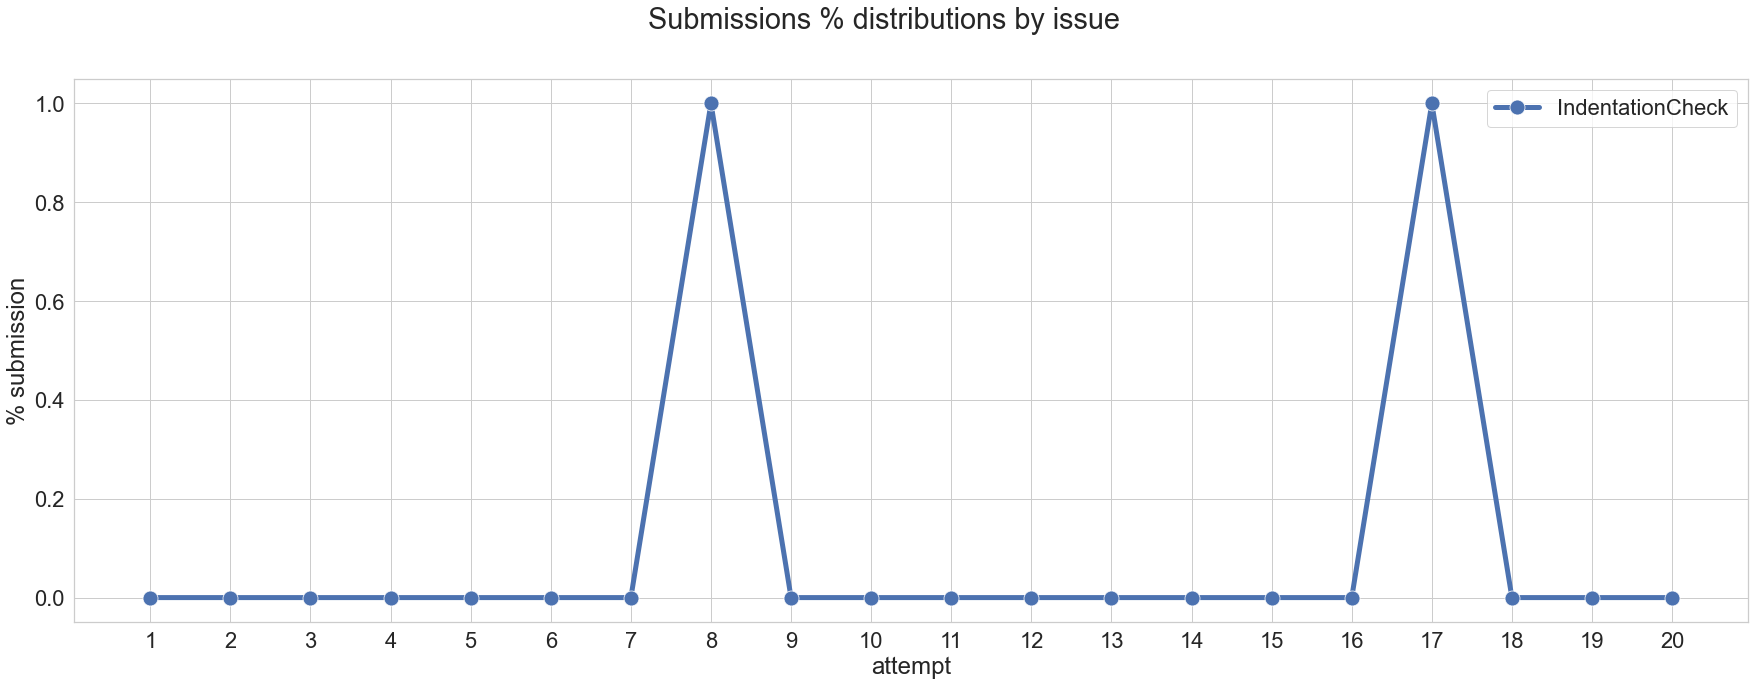

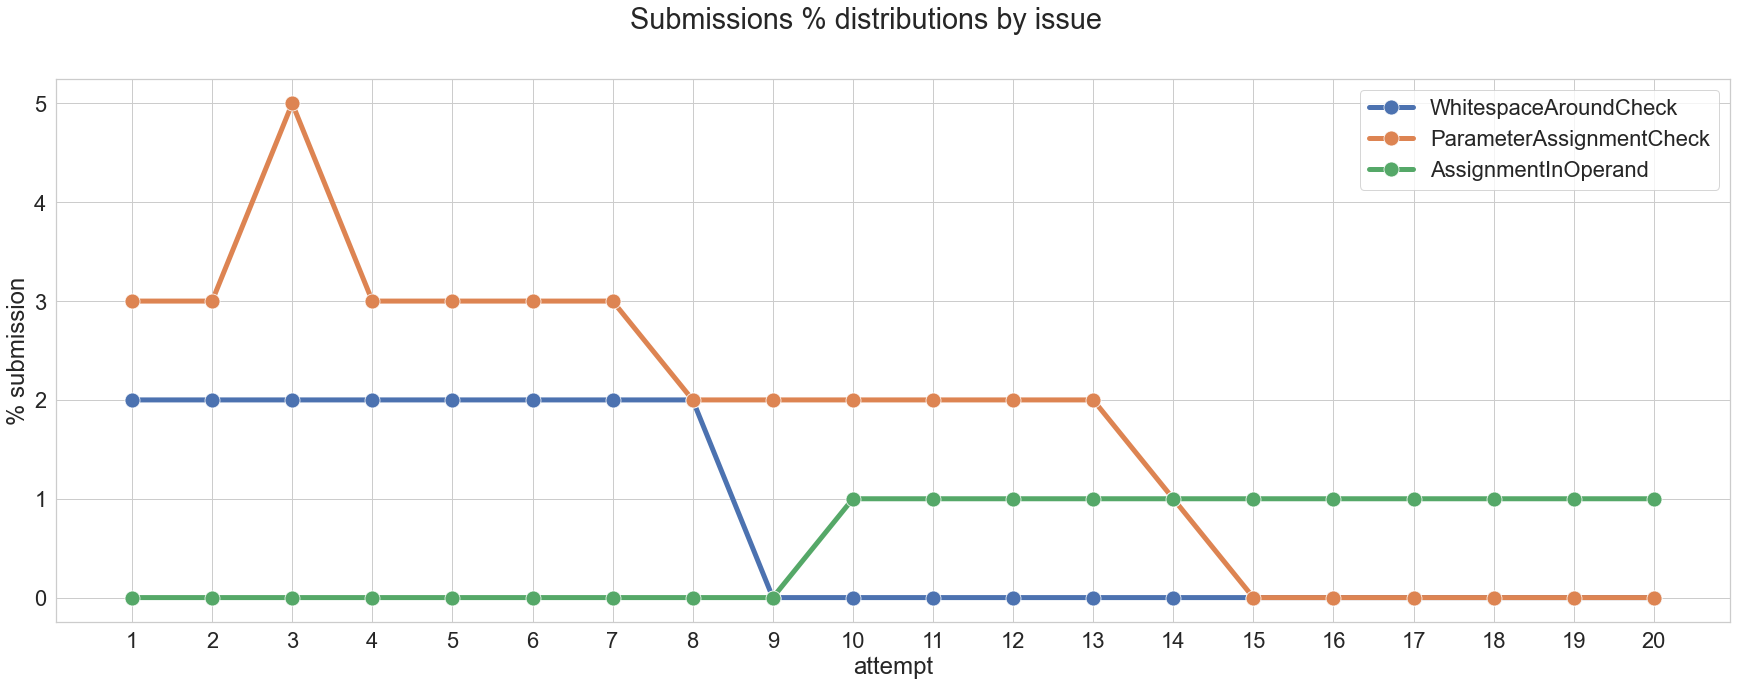

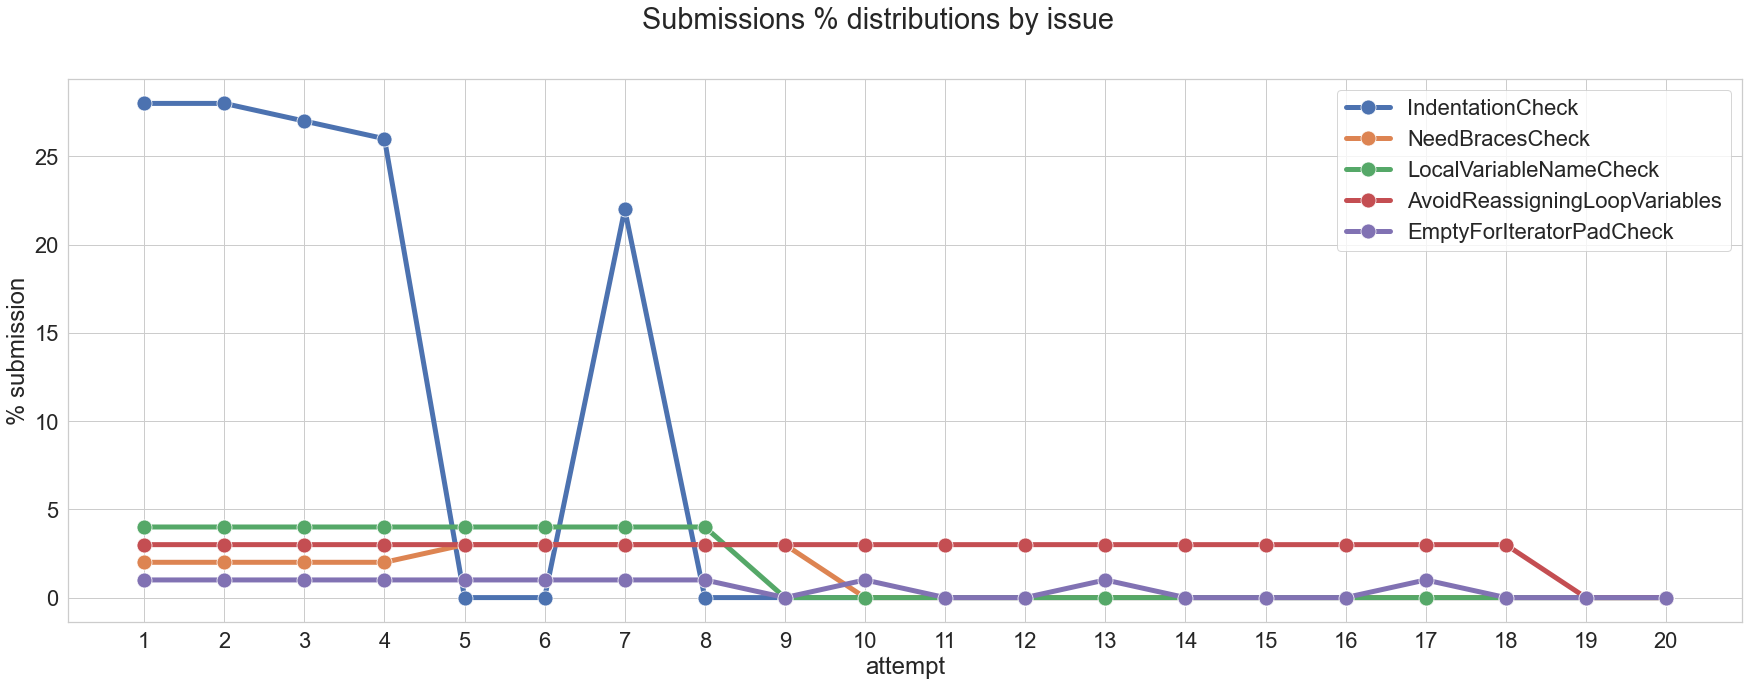

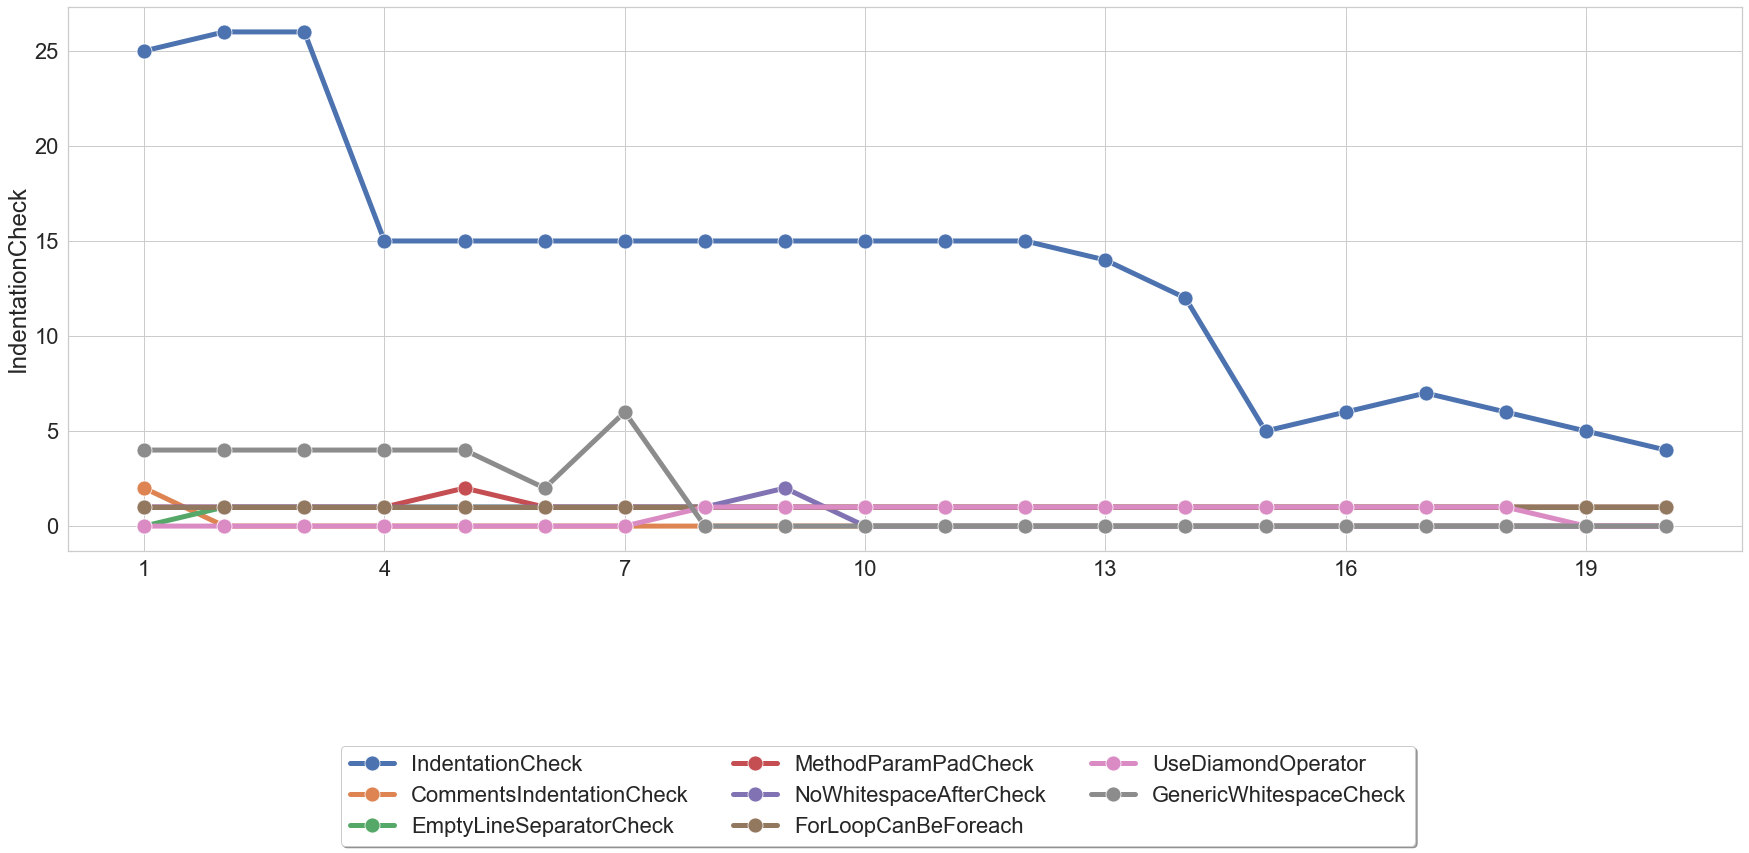

<Figure size 432x288 with 0 Axes>

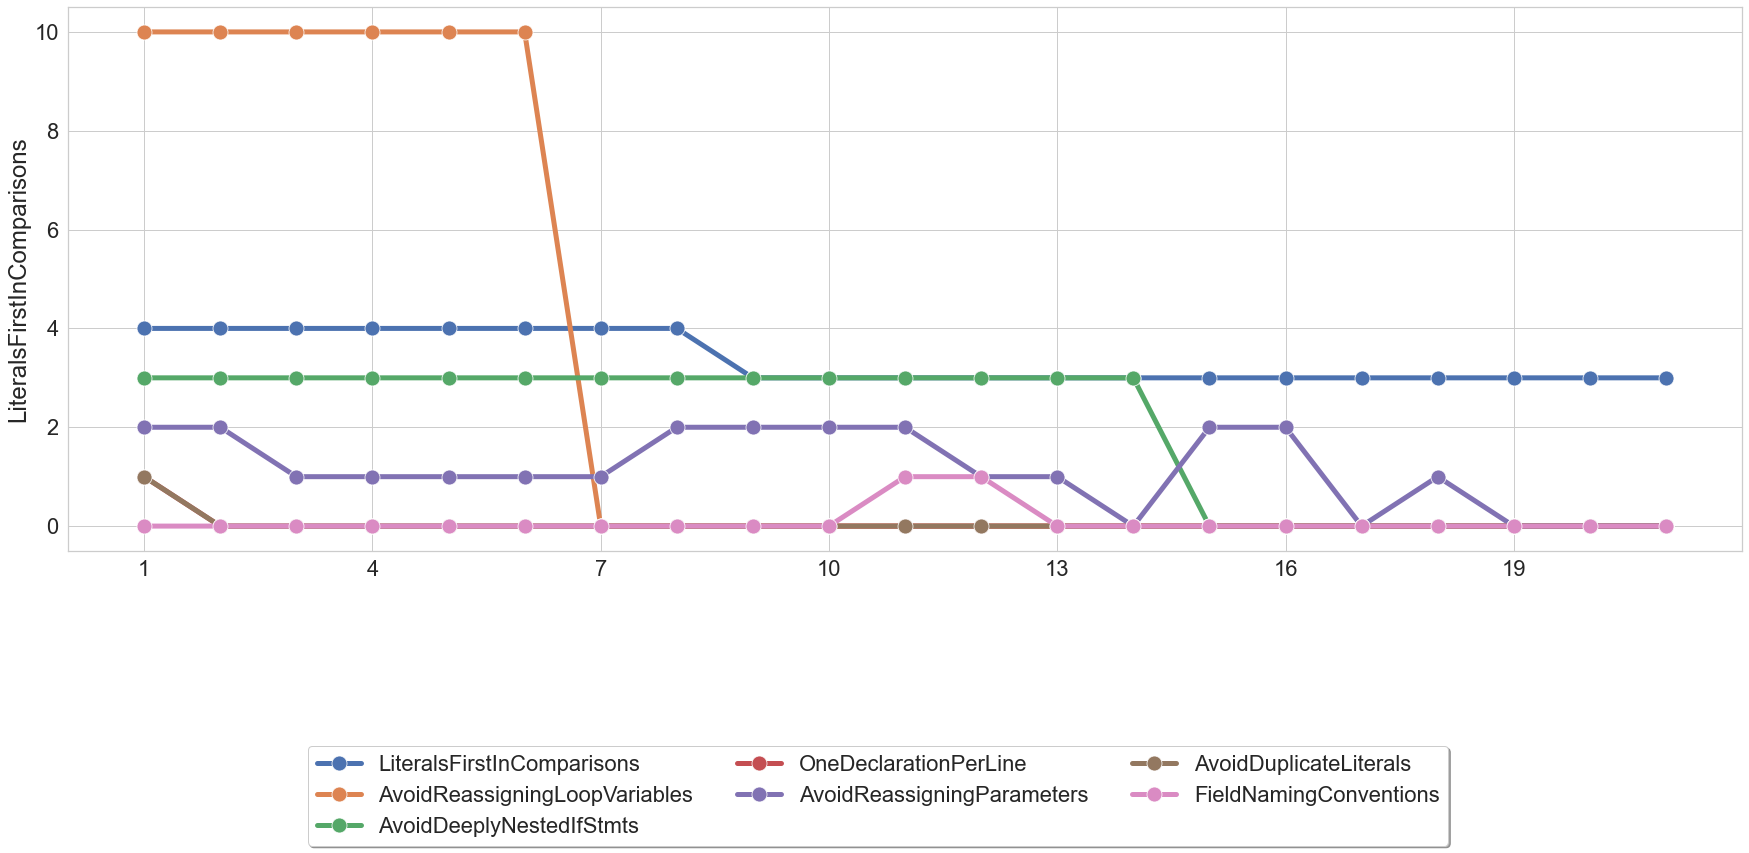

<Figure size 432x288 with 0 Axes>

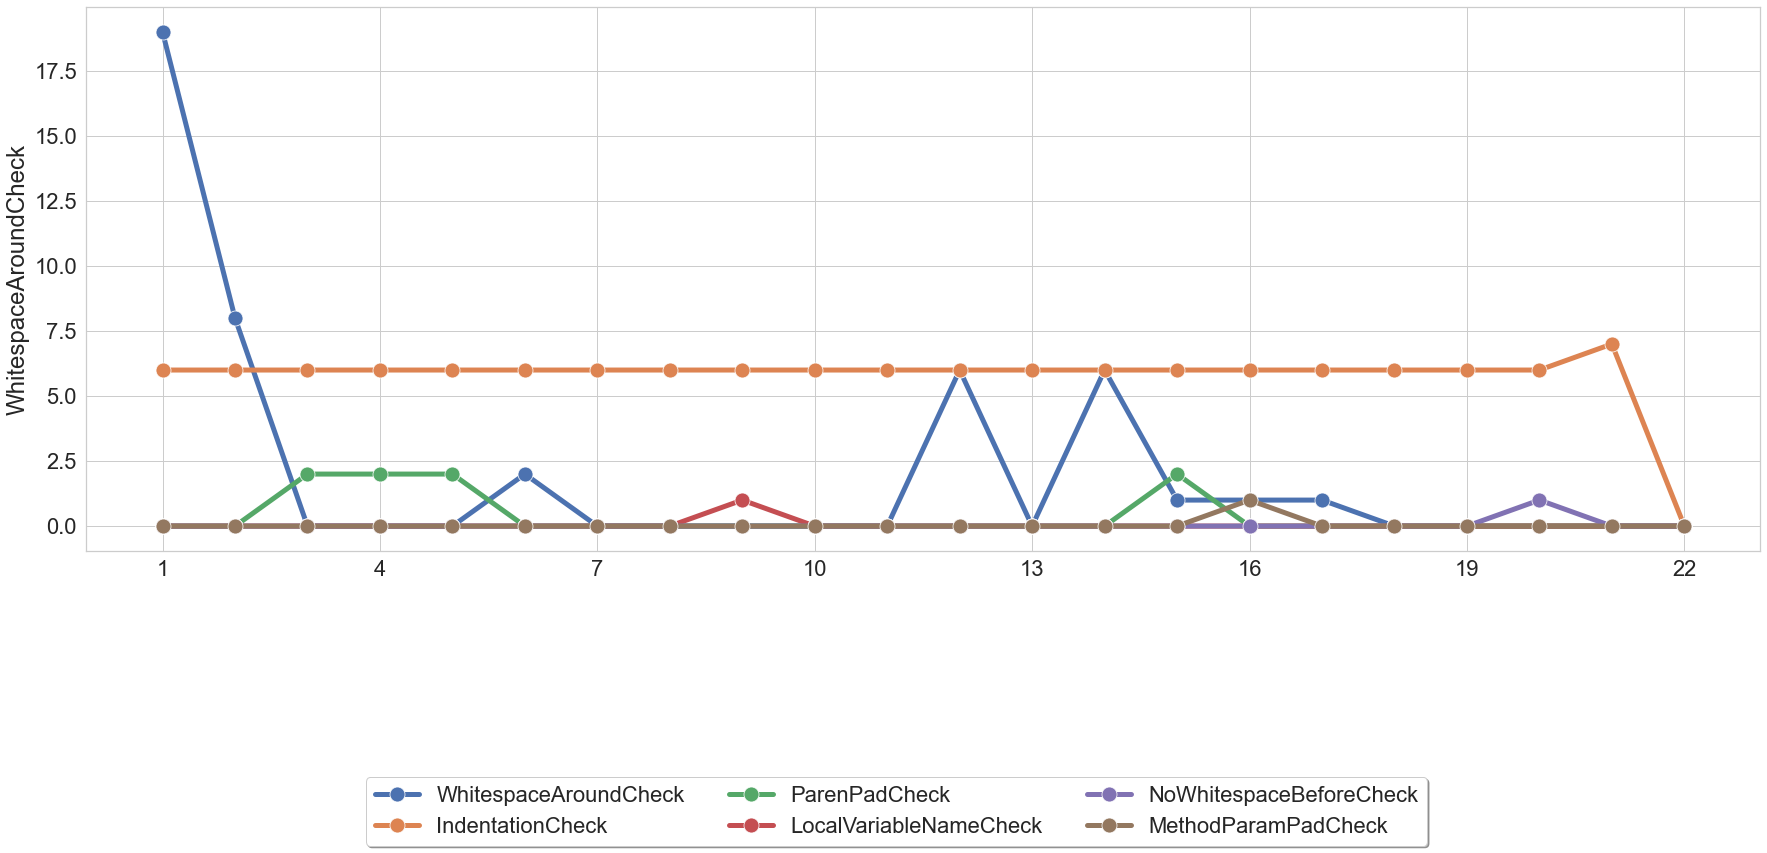

<Figure size 432x288 with 0 Axes>

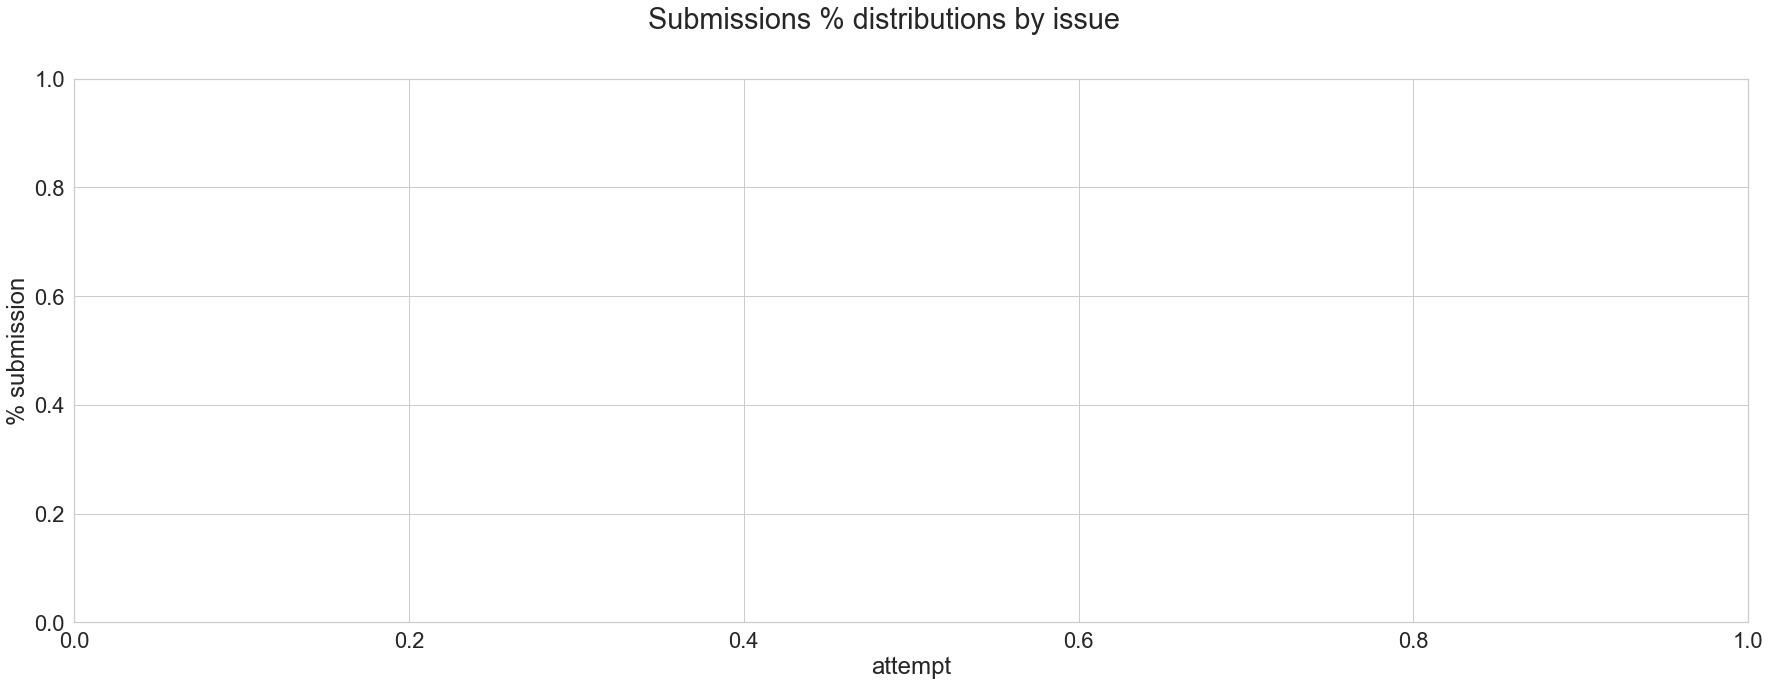

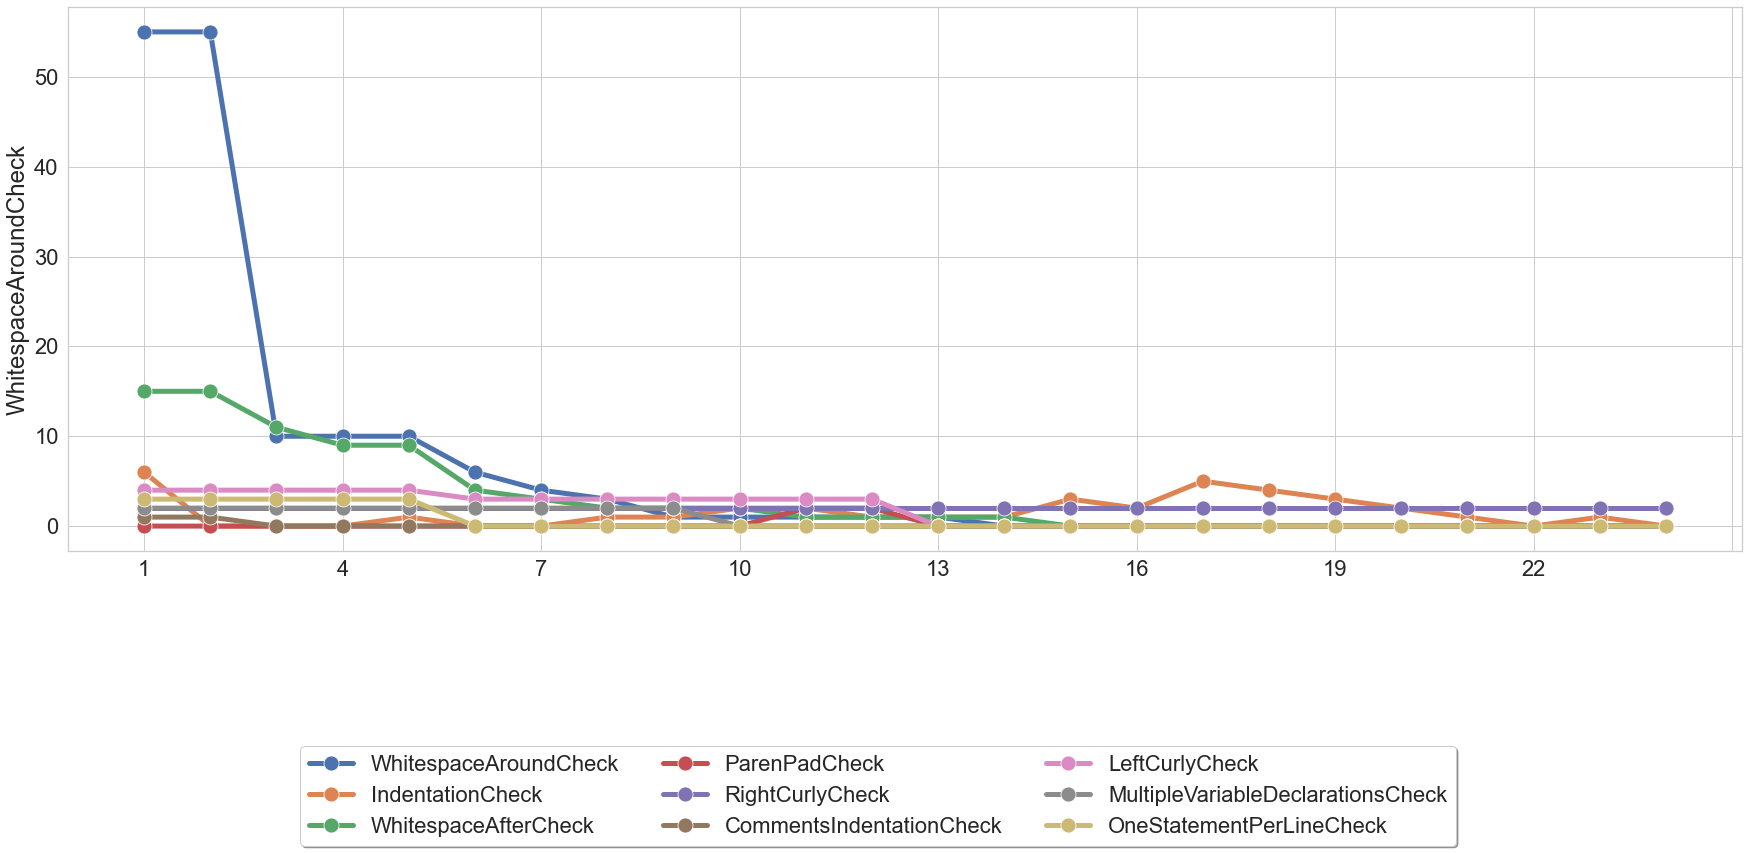

<Figure size 432x288 with 0 Axes>

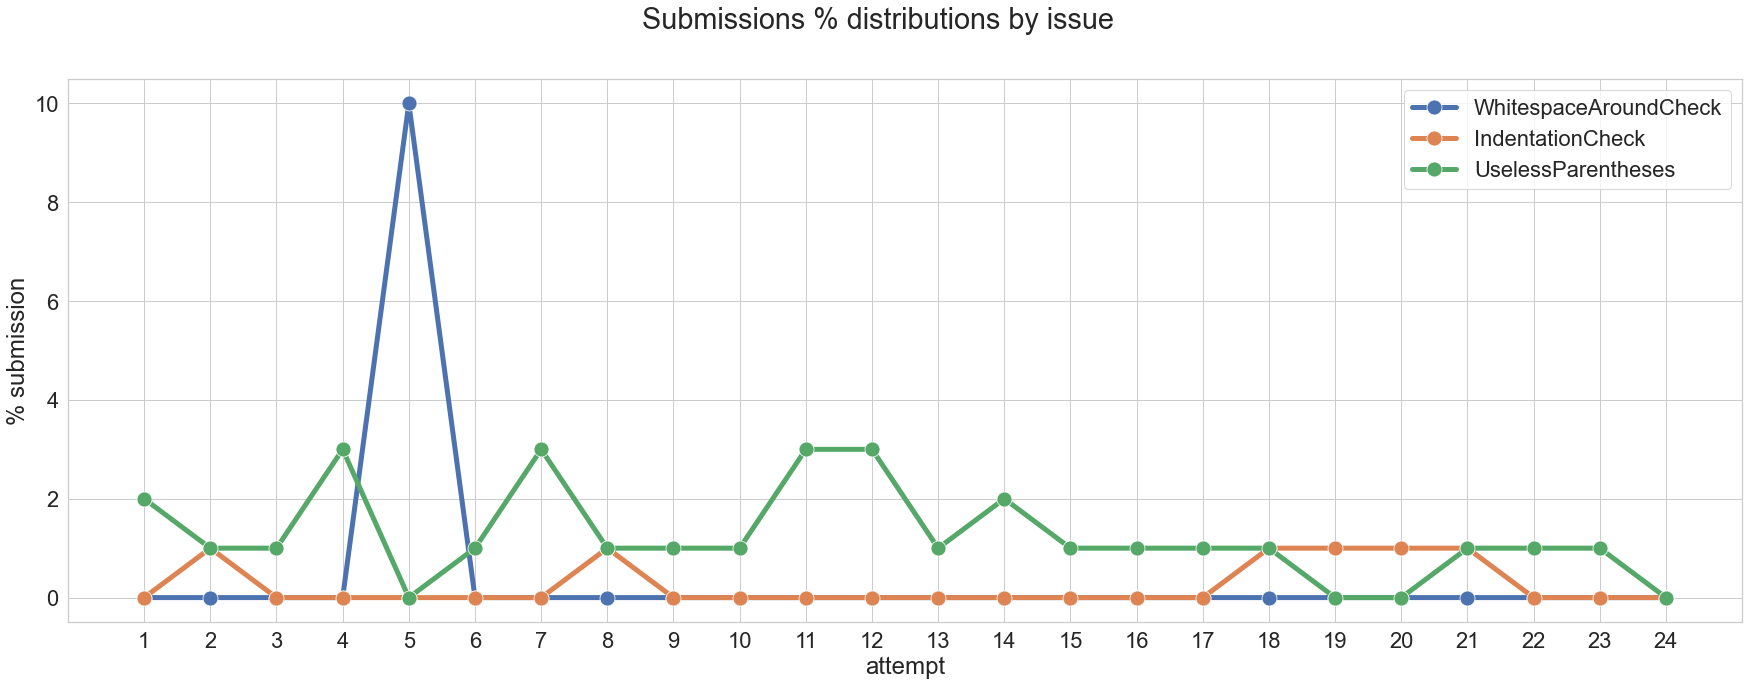

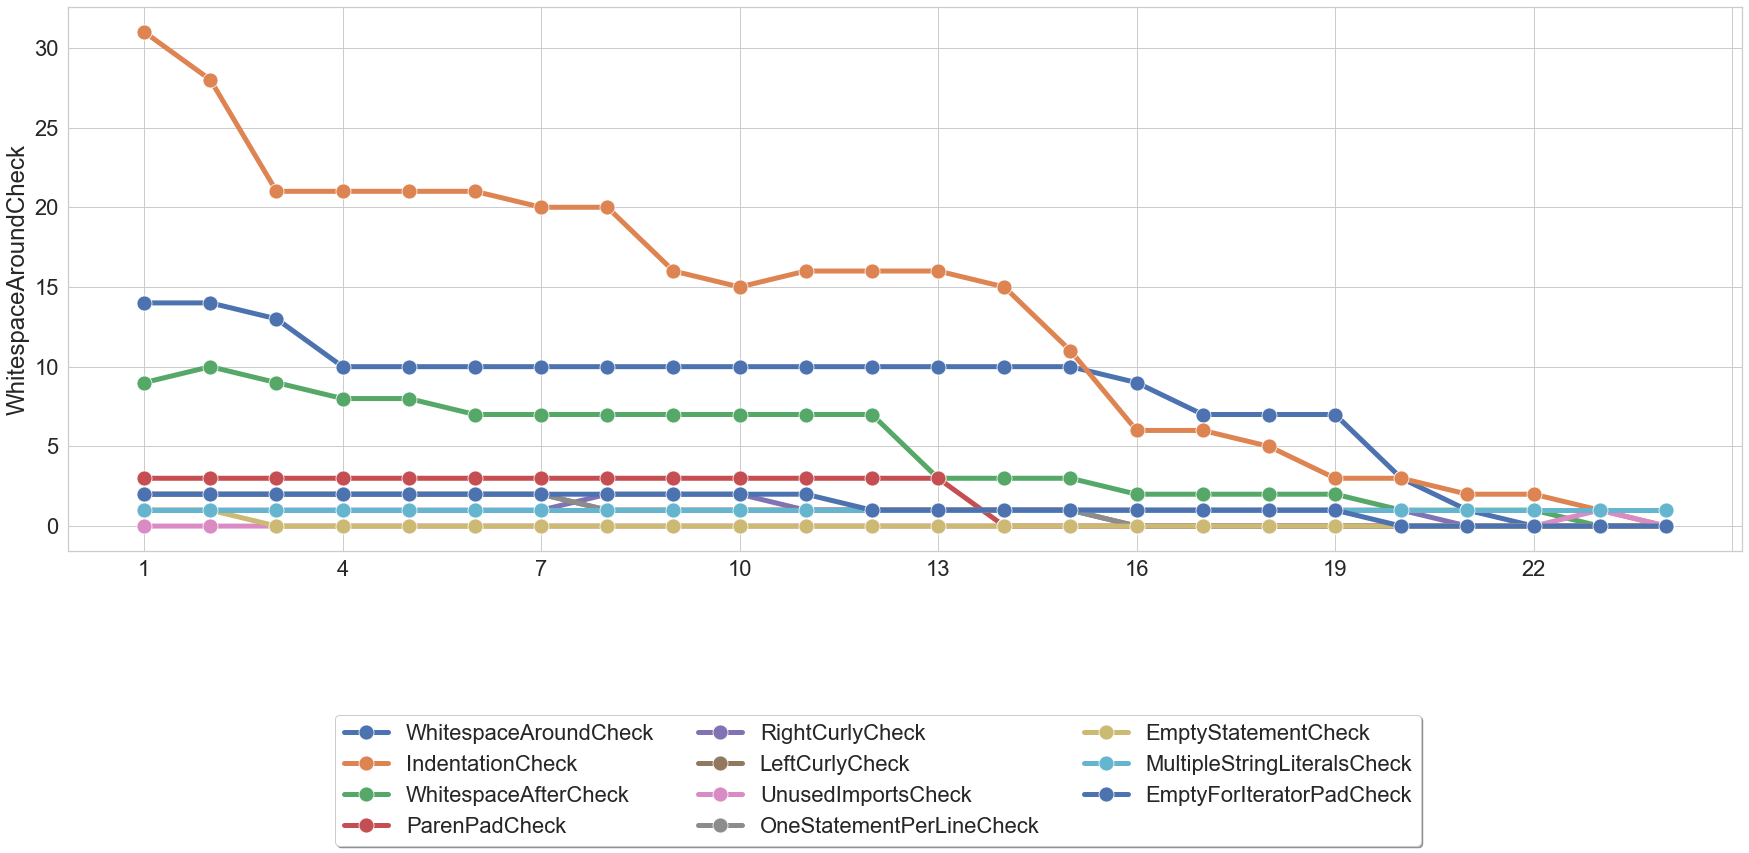

<Figure size 432x288 with 0 Axes>

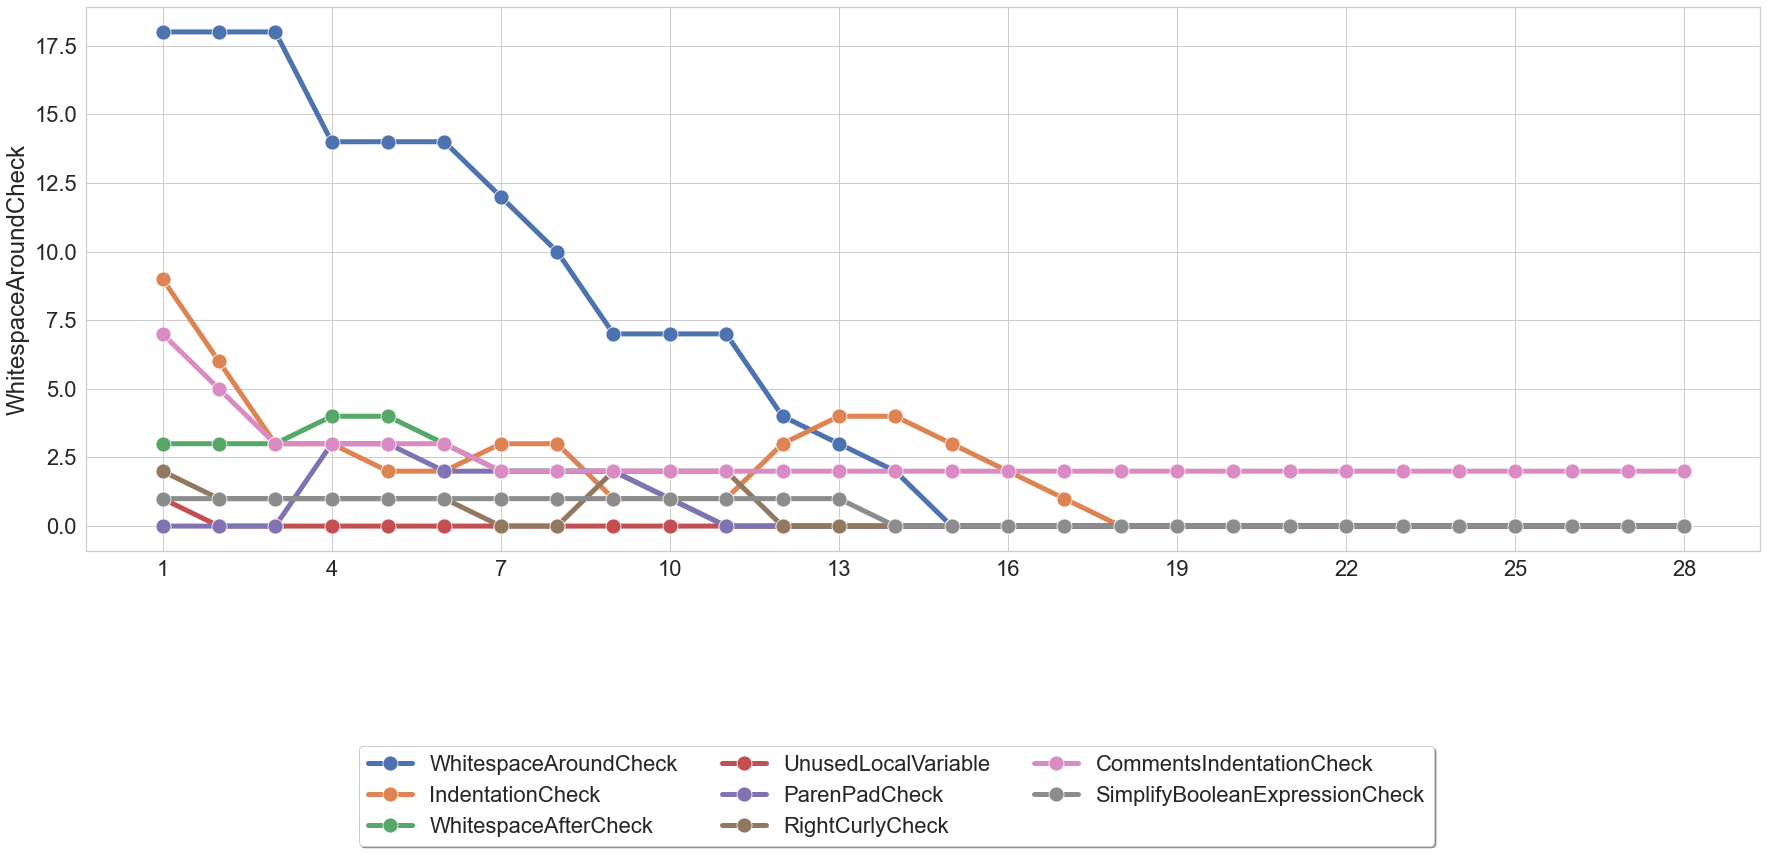

<Figure size 432x288 with 0 Axes>

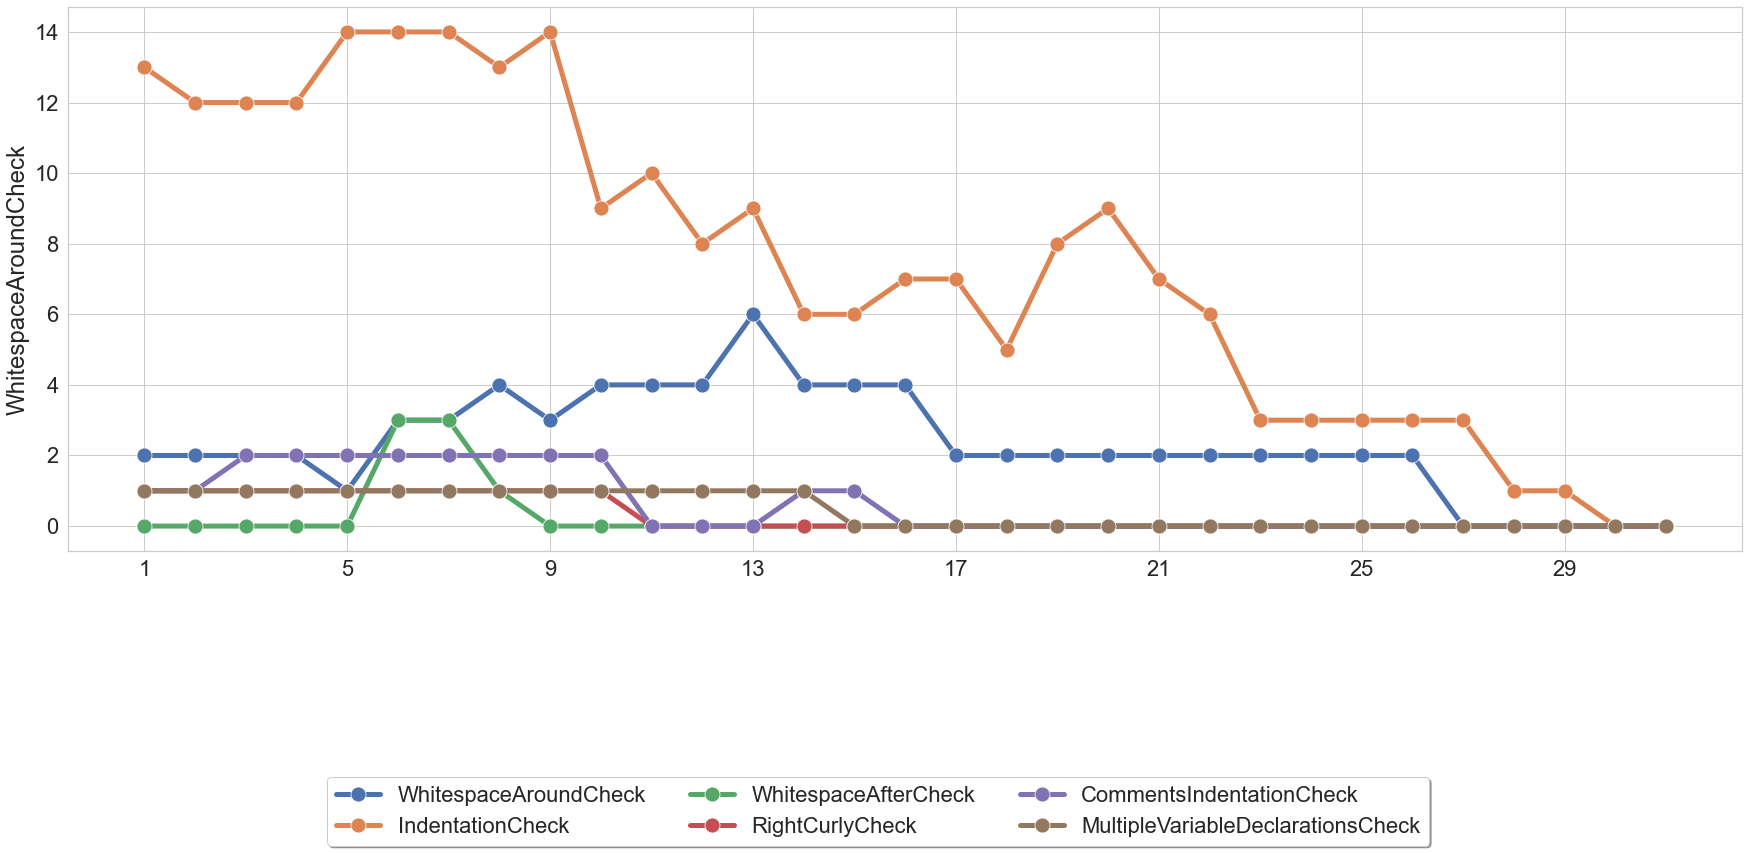

<Figure size 432x288 with 0 Axes>

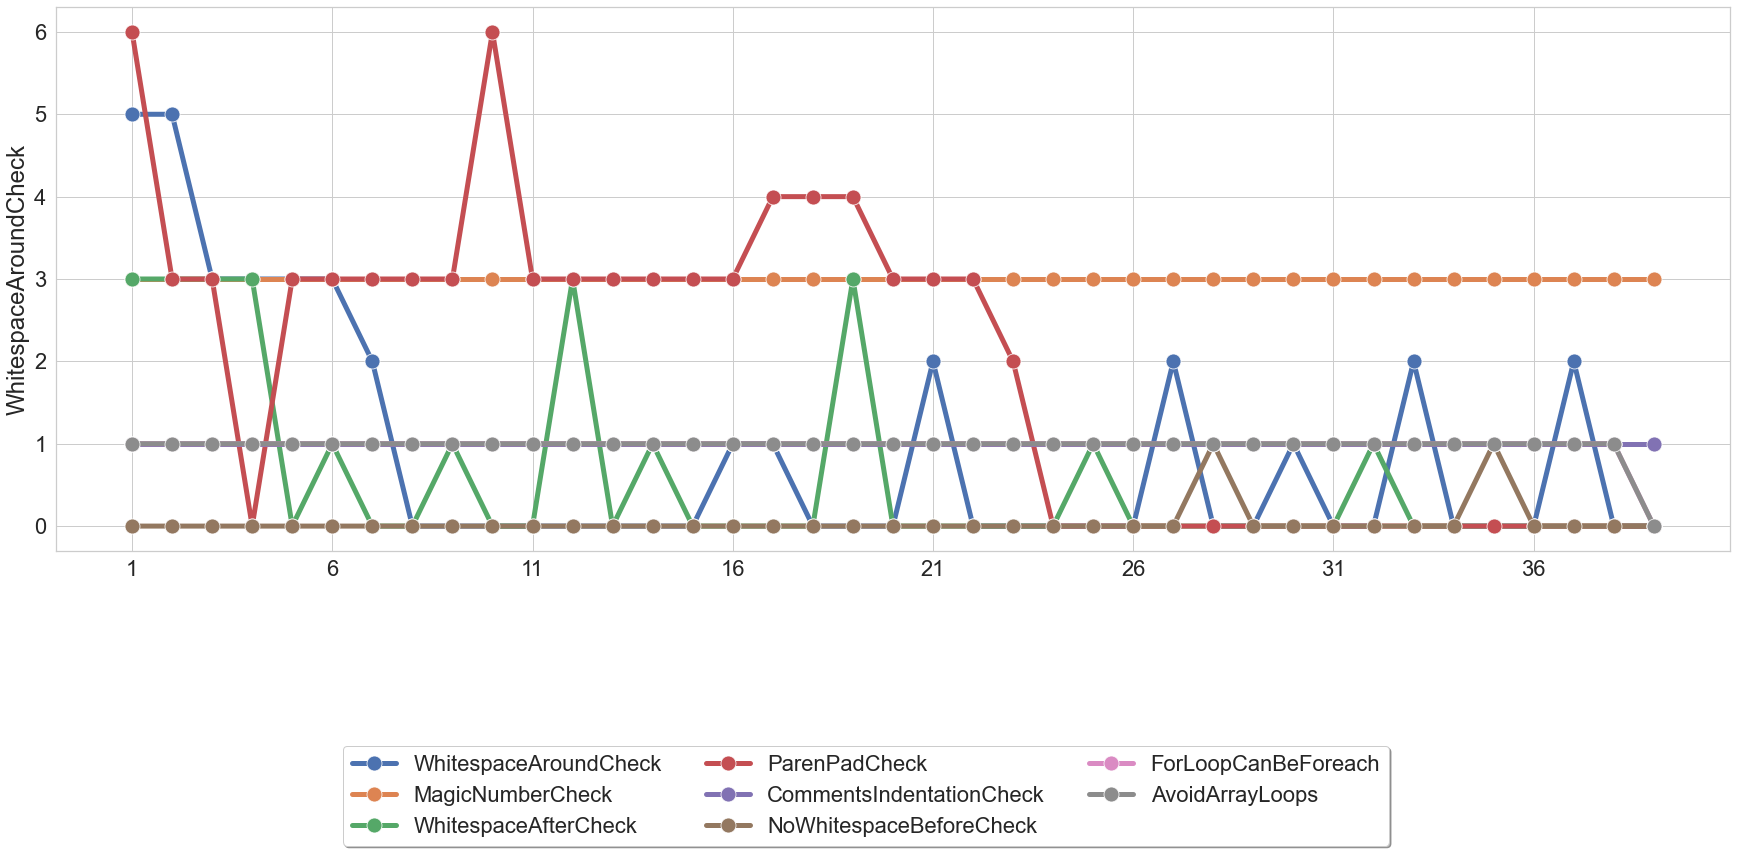

<Figure size 432x288 with 0 Axes>

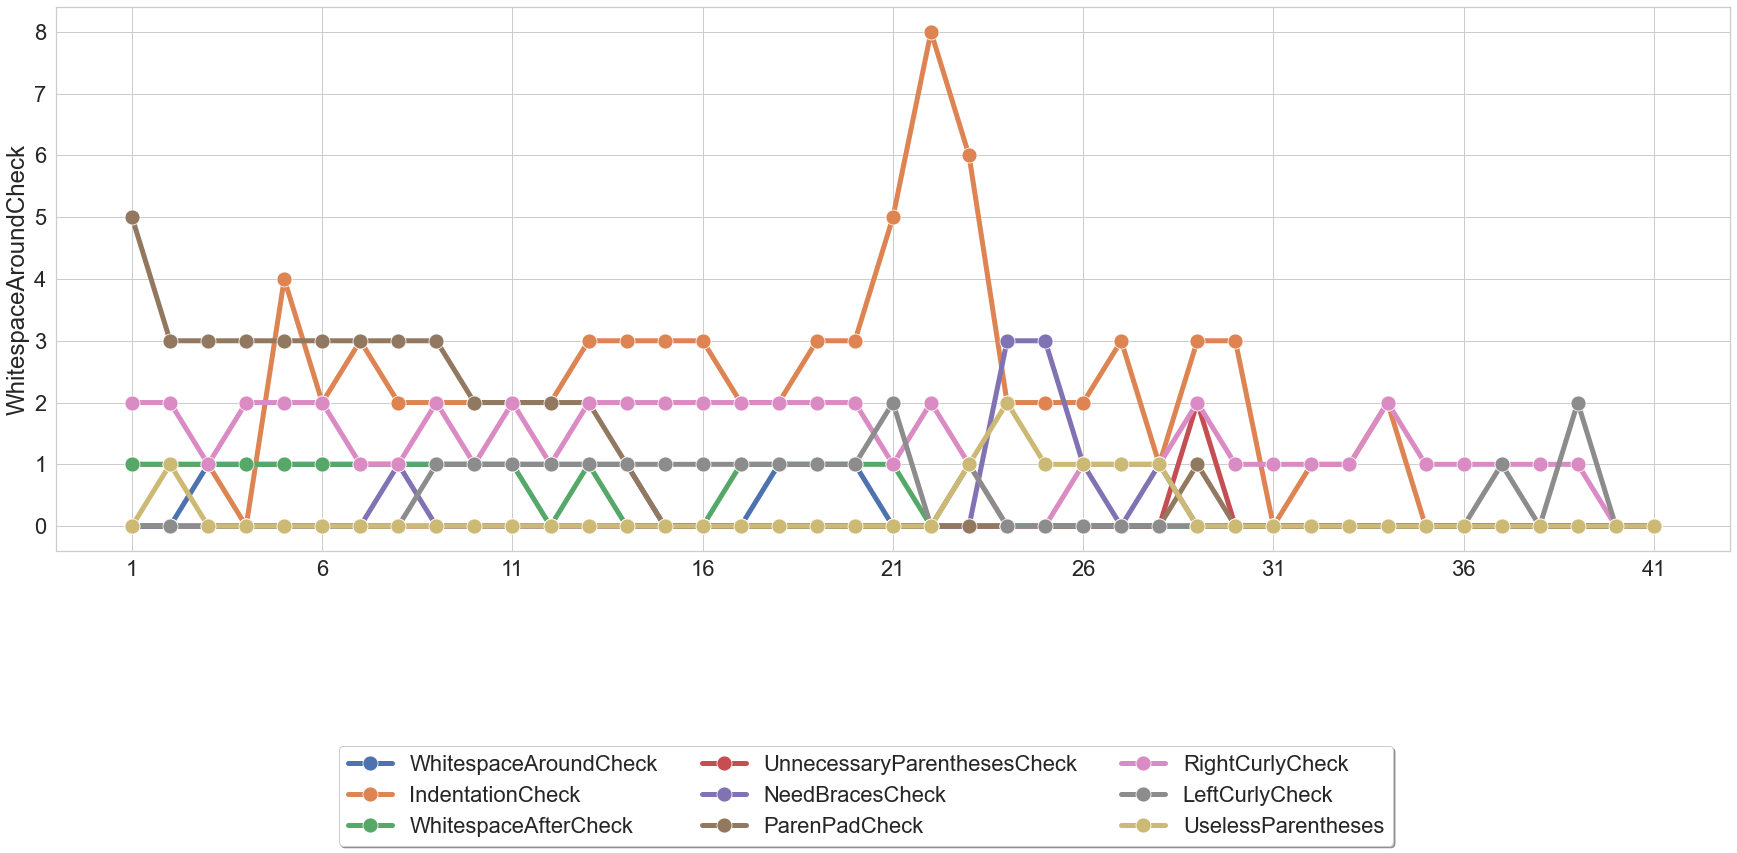

<Figure size 432x288 with 0 Axes>

In [18]:
for _, df_long_example in df_long_examples.iterrows():
    user_id = df_long_example['user_id']
    step_id = df_long_example['step_id']
    total_attempts = df_long_example['total_attempts']
    
    df_long_series = df_submissions_long[(df_submissions_long['step_id'] == step_id) & 
                                         (df_submissions_long['user_id'] == user_id)]

    df_long_issues = df_hyperstyle_issues_stats[df_hyperstyle_issues_stats['id'].isin(df_long_series['id'])]
    
    issues = [i for i in df_long_issues.columns if (i != 'id') and (df_long_issues[i].sum() > 0)]
    df_long_issues = df_long_issues[issues + ['id']]
    
    df_long_stats = pd.merge(df_long_series, df_long_issues, left_on='id', right_on='id')
    
    df_long_stats.to_csv(os.path.join(ATTEMPTS_STATS_PATH, f'submissions_{total_attempts}_{step_id}_{user_id}.csv'), 
                index=False)
    
    draw_compare(df_long_stats, 'attempt', ('issue', issues))